<a href="https://colab.research.google.com/github/g00dAA/Brain-Tumor-Segmentation/blob/main/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
import cv2
import math
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data preparation

## Building a dataframe with the images and masks

In [ ]:
# Initialize an empty list to store the photo and mask paths and their base names
data = []

# Path to the main directory containing subfolders with .tif photos and masks
main_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

# Loop over each subfolder in the main directory
for sub_dir_path in glob.glob(os.path.join(main_dir, "*")):
    if os.path.isdir(sub_dir_path):  # Ensure that it is a directory
        # Get all .tif files in the current subdirectory
        tif_files = [f for f in os.listdir(sub_dir_path) if f.endswith(".tif") and not f.endswith("_mask.tif")]

        # Map each photo to its corresponding mask
        for tif_file in tif_files:
            img_path = os.path.join(sub_dir_path, tif_file)
            mask_file = tif_file.replace(".tif", "_mask.tif")
            mask_path = os.path.join(sub_dir_path, mask_file)

            if os.path.exists(mask_path):  # Check if the mask file exists
                img_name = os.path.basename(img_path)
                mask_name = os.path.basename(mask_path)
                img_name, ext = os.path.splitext(img_name)
                mask_name, ext = os.path.splitext(mask_name)
                # data.append((photo_name, photo_path, mask_path))
                data.append((img_path, mask_path))
            else:
                print(f"Mask not found for photo: {img_path}")

# Create a Pandas DataFrame from the collected data
dataframe = pd.DataFrame(data, columns=['img_path', 'mask_path'])

## Converting .tif images and masks to .png

In [ ]:
def convert_tiff_to_png(image_path, mask_path):
    # Create folders if they don't exist
    os.makedirs("data", exist_ok=True)
    os.makedirs("labels", exist_ok=True)

    # Load TIFF image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convert TIFF to PNG
    image_output_path = os.path.join("/kaggle/working/data", os.path.basename(image_path).replace('.tif', '.png'))
    mask_output_path = os.path.join("/kaggle/working/labels", os.path.basename(mask_path).replace('.tif', '.png'))

    image.save(image_output_path, format='PNG')
    mask.save(mask_output_path, format='PNG')

In [ ]:
for index, row in dataframe.iterrows():
    img_path = row['img_path']
    mask_path = row['mask_path']

    # Convert TIFF to PNG
    convert_tiff_to_png(img_path, mask_path)

In [ ]:
def natural_sort_key(s):
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def sort_files_in_directory(directory_path):
    # Get the list of files in the specified directory
    contents = os.listdir(directory_path)

    # Filter out directories, only keep files
    files = [f for f in contents if os.path.isfile(os.path.join(directory_path, f))]

    # Sort the list of files using natural sorting
    sorted_files = sorted(files, key=natural_sort_key)

    return sorted_files

In [ ]:
sorted_imgs = sort_files_in_directory("/kaggle/working/data")
sorted_masks = sort_files_in_directory("/kaggle/working/labels")

data_dir = '/kaggle/working/data/'
sorted_imgs = [data_dir + item for item in sorted_imgs]

labels_dir = '/kaggle/working/labels/'
sorted_masks = [labels_dir + item for item in sorted_masks]

dataframe = pd.DataFrame({'img_path': sorted_imgs, 'mask_path': sorted_masks})

## Checking if the image has a brain tumor or not

In [ ]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 :
        return 1
    else:
        return 0

In [ ]:
dataframe['mask'] = dataframe['mask_path'].apply(lambda x: get_diagnosis(x))

In [ ]:
dataframe.head()

,img_path,mask_path,mask
0,/kaggle/working/data/TCGA_CS_4941_19960909_1.png,/kaggle/working/labels/TCGA_CS_4941_19960909_1...,0
1,/kaggle/working/data/TCGA_CS_4941_19960909_2.png,/kaggle/working/labels/TCGA_CS_4941_19960909_2...,0
2,/kaggle/working/data/TCGA_CS_4941_19960909_3.png,/kaggle/working/labels/TCGA_CS_4941_19960909_3...,0
3,/kaggle/working/data/TCGA_CS_4941_19960909_4.png,/kaggle/working/labels/TCGA_CS_4941_19960909_4...,0
4,/kaggle/working/data/TCGA_CS_4941_19960909_5.png,/kaggle/working/labels/TCGA_CS_4941_19960909_5...,0


In [ ]:
def print_shape():
    idx = np.random.randint(0, len(dataframe))

    img_path = dataframe.at[idx, 'img_path']
    mask_path = dataframe.at[idx, 'mask_path']

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}\n")

In [ ]:
for i in range(5):
    print_shape()

Image shape: (256, 256, 3), Mask shape: (256, 256, 3)

Image shape: (256, 256, 3), Mask shape: (256, 256, 3)

Image shape: (256, 256, 3), Mask shape: (256, 256, 3)

Image shape: (256, 256, 3), Mask shape: (256, 256, 3)

Image shape: (256, 256, 3), Mask shape: (256, 256, 3)



In [ ]:
def plot_images(dataframe, num_plots=5):
    count = 0  # Counter to track the number of plots

    while count < num_plots:
        idx = np.random.randint(0, len(dataframe))

        img_path = dataframe.at[idx, 'img_path']
        mask_path = dataframe.at[idx, 'mask_path']

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        if dataframe.at[idx, 'mask'] == 1:
            _, axs = plt.subplots(1, 3, figsize=[13, 15])
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Brain MRI')
            axs[0].grid(False)

            axs[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Mask')
            axs[1].grid(False)

            axs[2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[2].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB), alpha=0.3)
            axs[2].set_title('MRI with mask')
            axs[2].grid(False)

            plt.show()

            count += 1

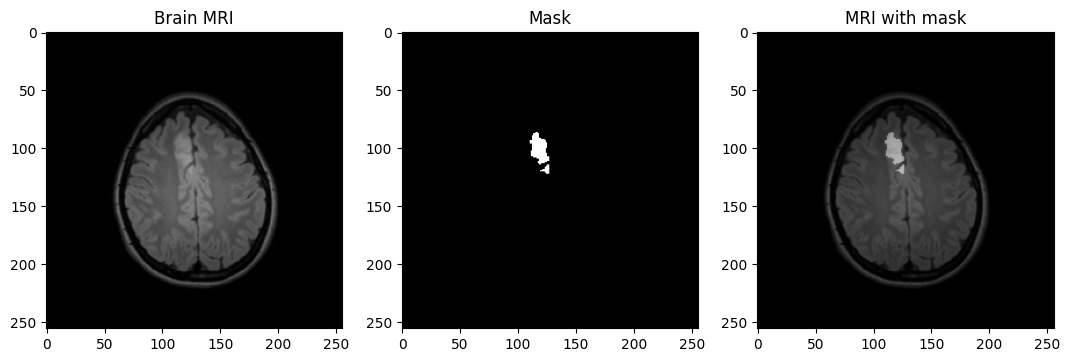

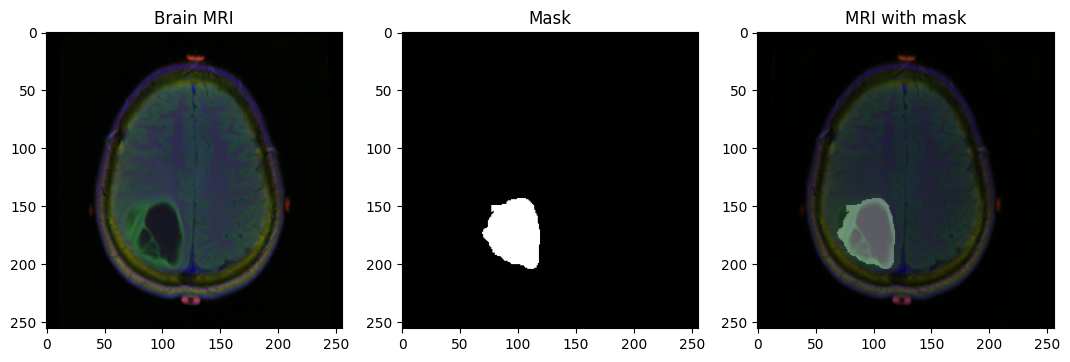

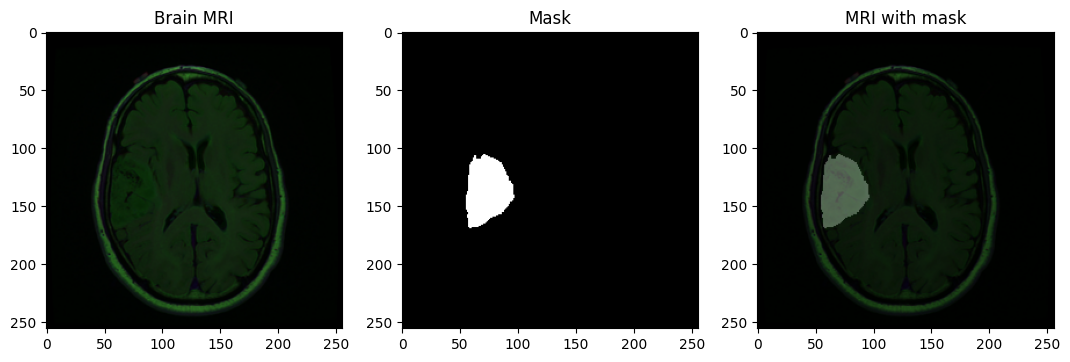

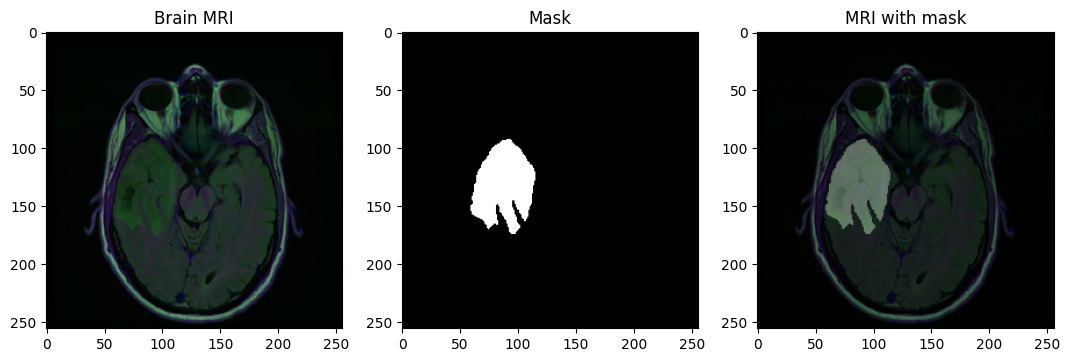

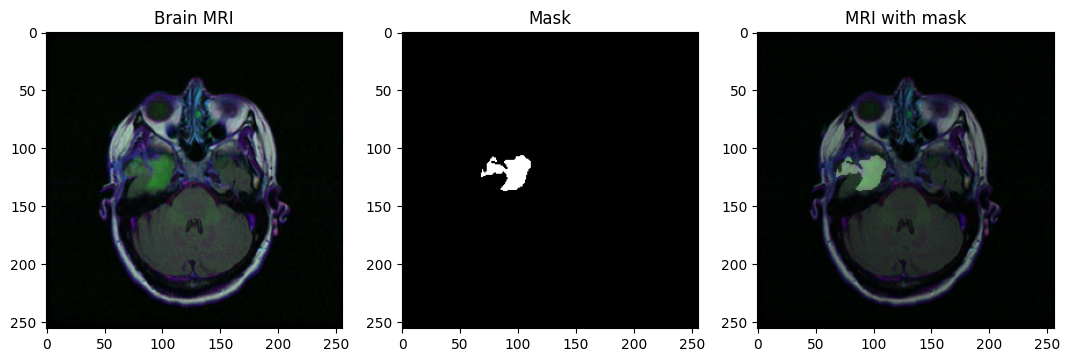

In [ ]:
plot_images(dataframe, 5)

In [ ]:
# Transformations (with data augmentation)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
def process_images(image_paths, transform, type="mask"):
    processed_images = []

    for path in image_paths:
        # Open the image
        img = Image.open(path)
        # Convert the image to grayscale
        if type == 'mask':
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        # Apply the defined transforms
        img_transformed = transform(img)
        # Append the transformed image tensor to the list
        processed_images.append(img_transformed)

    # Stack all image tensors into a single tensor of shape (N, 1, 224, 224)
    images_tensor = torch.stack(processed_images)

    return images_tensor

In [ ]:
images = process_images(sorted_imgs, data_transform, "image")
masks = process_images(sorted_masks, target_transform)

In [ ]:
images.shape, masks.shape

(torch.Size([3929, 3, 224, 224]), torch.Size([3929, 1, 224, 224]))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.20, shuffle=True)

In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(TensorDataset(X_train,Y_train), batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(TensorDataset(X_test,Y_test), batch_size=BATCH_SIZE, shuffle=True)

# Swin U-Net architecture

In [ ]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [ ]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x

In [ ]:
def train(model, dataloader, loss_func, optimizer):
    model.train()
    loss_values = []
    acc_values = []
    for _, (data, labels) in enumerate(dataloader):
      data = data.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      pred = model(data)
      loss = loss_func(pred, labels)
      loss_values.append(loss.item())
      loss.backward()
      optimizer.step()
      acc_value = (pred.argmax(axis = 1) == labels).type(torch.float32)
      acc_values.append(acc_value.mean().item())
    return np.mean(loss_values), np.mean(acc_values)

def validate(model, dataloader, loss_func):
    model.eval()
    loss_values = []
    acc_values = []
    with torch.no_grad():
      for _, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        labels = labels.to(device)
        pred = model(data)
        loss = loss_func(pred, labels)
        loss_values.append(loss.item())
        acc_value = (pred.argmax(axis = 1) == labels).type(torch.float32)
        acc_values.append(acc_value.mean().item())
    return np.mean(loss_values), np.mean(acc_values)

def tune_model(epochs, model, train_dataloader, test_dataloader, loss_func, optimizer):
    for epoch in range(epochs):
      train_loss, train_acc = train(model, train_dataloader, loss_func, optimizer)
      test_loss, test_acc = validate(model, test_dataloader, loss_func)
      print(f"Epoch : {epoch + 1} || Train loss : {train_loss:5.3f} || Train accuracy : {train_acc:5.3f}", end="")
      print(f" || Test loss : {test_loss:5.3f} || Test accuracy : {test_acc:5.3f}")

In [ ]:
model = SwinUNet(224,224,3,32,1,3,4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss()
tune_model(10, model, train_dataloader, test_dataloader, loss_fn, optimizer)

Epoch : 1 || Train loss : 0.072 || Train accuracy : 0.989 || Test loss : 0.041 || Test accuracy : 0.989
Epoch : 2 || Train loss : 0.043 || Train accuracy : 0.989 || Test loss : 0.040 || Test accuracy : 0.989
Epoch : 3 || Train loss : 0.040 || Train accuracy : 0.989 || Test loss : 0.036 || Test accuracy : 0.989
Epoch : 4 || Train loss : 0.038 || Train accuracy : 0.989 || Test loss : 0.035 || Test accuracy : 0.989
Epoch : 5 || Train loss : 0.038 || Train accuracy : 0.989 || Test loss : 0.035 || Test accuracy : 0.989
Epoch : 6 || Train loss : 0.037 || Train accuracy : 0.989 || Test loss : 0.036 || Test accuracy : 0.989
Epoch : 7 || Train loss : 0.036 || Train accuracy : 0.989 || Test loss : 0.035 || Test accuracy : 0.989
Epoch : 8 || Train loss : 0.036 || Train accuracy : 0.989 || Test loss : 0.035 || Test accuracy : 0.989
Epoch : 9 || Train loss : 0.035 || Train accuracy : 0.989 || Test loss : 0.033 || Test accuracy : 0.989
Epoch : 10 || Train loss : 0.034 || Train accuracy : 0.989 || Te

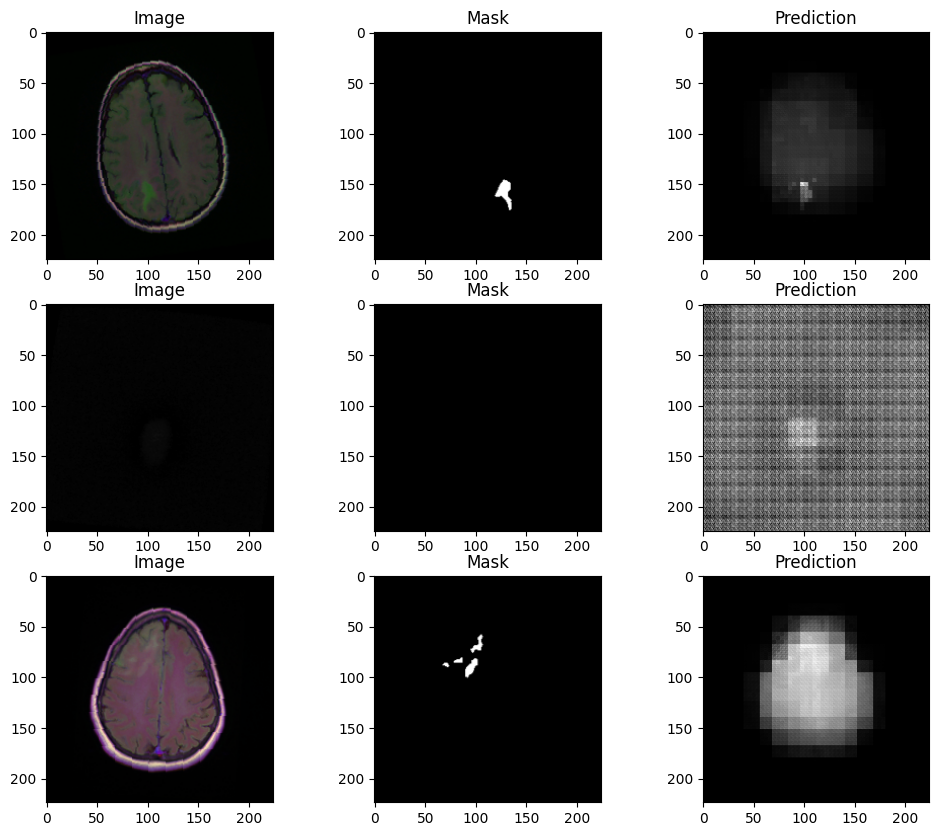

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
with torch.no_grad():
    for i in range(3):
        x_og, y_og = next(iter(train_dataloader))
        x = x_og[0]
        y = y_og[0]


        # Plot the original image with three channels
        ax[i, 0].imshow(x.permute(1, 2, 0).cpu().numpy())  # Convert from [C, H, W] to [H, W, C]
        ax[i, 0].set_title('Image')

        # Plot the mask
        ax[i, 1].imshow(y.squeeze(0).cpu().numpy(), cmap='gray')
        ax[i, 1].set_title('Mask')

        x_og = x_og.to(device)

        # Get the model output
        out = model(x_og[:1])
        out = nn.Sigmoid()(out)

        # Process the output to be 2D for visualization
        out = out.squeeze(0).squeeze(0).cpu()


        # Plot the prediction
        ax[i, 2].imshow(out, cmap='gray')
        ax[i, 2].set_title('Prediction')

plt.show()